# Comparison of various low rank approximations

## Setup simple regression model

In [5]:
import sys
import os

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

In [6]:
from tests.test_eval.cases.regression import NNXRegressionTask

# Setup simple regression
task = NNXRegressionTask(
    in_channels=8,
    hidden_channels=64,
    out_channels=1,
    seed=0
)
model_fn = task.get_model_fn()
params = task.get_parameters()
data = task.get_data_batch(batch_size=20)
results = {}

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
from laplax.curv.ggn import create_ggn_mv
from laplax.util.flatten import create_pytree_flattener, wrap_function
from laplax.util.mv import todense
from laplax.util.tree import get_size

# Setup GGN
ggn_mv = create_ggn_mv(model_fn, params, data, task.loss_fn_type)
flatten, unflatten = create_pytree_flattener(params)
ggn_mv_wrapped = wrap_function(ggn_mv, input_fn=unflatten, output_fn=flatten)

# Get full ggn
# ggn_full = todense(ggn_mv, layout=params)
ggn_full = todense(ggn_mv_wrapped, layout=get_size(params))

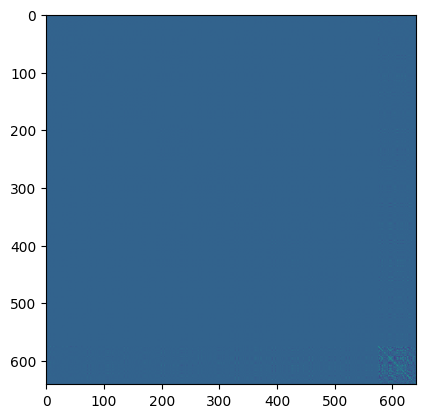

In [8]:
import matplotlib.pyplot as plt 

plt.imshow(ggn_full)

## LOBPCG

In [9]:
# Setup
import jax
import jax.numpy as jnp

from laplax.curv.lanczos import lobpcg_standard


def ggn_matmul(X):
    return jax.vmap(ggn_mv_wrapped)(X.T).T


key = jax.random.key(0)
m = 100
X = jax.random.normal(key, (get_size(params), m))

### LOBPCG with JIT

In [10]:
import time

# Time the function
start_time = time.perf_counter()
low_rank = lobpcg_standard(ggn_matmul, X, m, A_jittable=True)
acc = jnp.sum(jnp.abs(ggn_full - (low_rank[1] @ jnp.diag(low_rank[0]) @ low_rank[1].T)))
print(f"Accuracy: {acc:.8f}")

# Stop timer
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

results["lobpcg_with_jit"] = {"acc": acc, "time": elapsed_time}

Accuracy: 0.47185150
Elapsed time: 4.6082 seconds


## LOBPCG without JIT and mixed precision

In [56]:
import time

# Time the function
start_time = time.perf_counter()

ggn_matmul_jit = jax.jit(ggn_matmul)

with jax.experimental.enable_x64():
    low_rank = lobpcg_standard(ggn_matmul_jit, X, m, A_jittable=False)

low_rank = jax.tree.map(lambda x: jnp.asarray(x, dtype=jnp.float32), low_rank)
acc = jnp.sum(jnp.abs(ggn_full - (low_rank[1] @ jnp.diag(low_rank[0]) @ low_rank[1].T)))
print(f"Accuracy: {acc:.8f}")

# Stop timer
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

results["lobpcg_wo_jit"] = {"acc": acc, "time": elapsed_time}

Accuracy: 0.01356582
Elapsed time: 10.5155 seconds


## Skerch

In [84]:
import numpy as np
import torch
from skerch import linops


class GGNJAX(linops.TorchLinOpWrapper):  # noqa: D101
    def __init__(self, ggn_mv, shape) -> None:  # noqa: D107
        super().__init__()
        self.shape = shape
        self.ggn_mv = ggn_mv

    def __matmul__(self, x: torch.tensor) -> torch.tensor:  # noqa: D105
        res_jax = self.ggn_mv(
            jnp.asarray(x.detach().cpu().numpy())
        )
        return torch.tensor(np.asarray(res_jax))

    def __rmatmul__(self, x: torch.tensor) -> torch.tensor:  # noqa: D105
        res = self.__matmul__(x.T)
        return res

In [85]:
from skerch.decompositions import seigh

# Time the function
start_time = time.perf_counter()

# Setup skerch operator
n_params = get_size(params)
op = GGNJAX(jax.jit(ggn_mv_wrapped), (n_params, n_params))

res = seigh(
    op,
    op_device="cpu",
    op_dtype=torch.float64,
    outer_dim=m,
    inner_dim=m
)

U = jnp.asarray((res[0] @ res[1]).detach().numpy(), jnp.float32)
S = jnp.asarray(res[2].detach().numpy(), jnp.float32)
S = jnp.where(S < 0, 0, S)

acc = jnp.sum(jnp.abs(ggn_full - U @ jnp.diag(S) @ U.T))

print(f"Accuracy: {acc:.8f}")

# Stop timer
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

results["skerch"] = {"acc": acc, "time": elapsed_time}

Accuracy: 0.06479877
Elapsed time: 0.3379 seconds


## Plot results

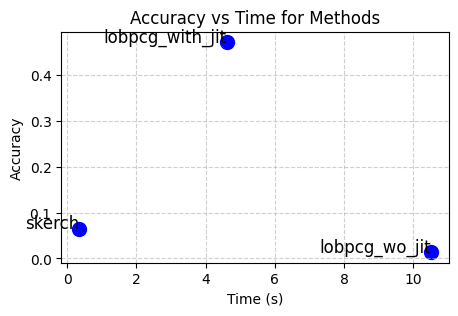

In [86]:
# Extract data for plotting
methods = list(results.keys())
acc_values = [results[method]["acc"] for method in methods]
time_values = [results[method]["time"] for method in methods]

# Create the plot
plt.figure(figsize=(5, 3))
plt.scatter(time_values, acc_values, color='b', s=100)

# Annotate points
for method, x, y in zip(methods, time_values, acc_values):
    plt.text(x, y, method, fontsize=12, ha='right')

# Customize the plot
plt.title("Accuracy vs Time for Methods")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Here `lobpcg_with_jit` operates currently with lower precision.

## Bonus: Register skerch.seigh as an alternative curvature approximation

In [83]:
from skerch.decompositions import seigh

import laplax
from laplax.curv.cov import (
    CURVATURE_METHODS,
    CURVATURE_PRIOR_METHODS,
    CURVATURE_STATE_TO_COV,
    CURVATURE_STATE_TO_SCALE,
    CURVATURE_TO_POSTERIOR_STATE,
    low_rank_prec_to_state,
    low_rank_state_to_cov,
    low_rank_state_to_scale,
    low_rank_with_prior,
)
from laplax.types import Callable


# Define how to approximate curvature
def create_sketched_curvature(mv: Callable, **kwargs):
    layout = kwargs.get("layout")
    flatten, unflatten = laplax.util.flatten.create_pytree_flattener(layout)
    nparams = laplax.util.tree.get_size(layout)
    mv = jax.jit(wrap_function(fn=mv, input_fn=unflatten, output_fn=flatten))
    op = GGNJAX(mv, shape=(nparams, nparams))

    res = seigh(
        op,
        op_device="cpu",
        op_dtype=torch.float64,
        outer_dim=100,
        inner_dim=100
    )
    U = jnp.asarray((res[0] @ res[1]).detach().numpy(), jnp.float32)
    S = jnp.asarray(res[2].detach().numpy(), jnp.float32)
    eps = jnp.finfo(S.dtype).eps
    S = jnp.where(S < eps, eps, S)

    return {
        "U": U,
        "S": S,
    }


# Register all method
CURVATURE_METHODS.update({"skerch": create_sketched_curvature})
CURVATURE_PRIOR_METHODS.update({"skerch": low_rank_with_prior})
CURVATURE_TO_POSTERIOR_STATE.update({"skerch": low_rank_prec_to_state})
CURVATURE_STATE_TO_SCALE.update({"skerch": low_rank_state_to_scale})
CURVATURE_STATE_TO_COV.update({"skerch": low_rank_state_to_cov})

In [79]:
from laplax.curv.cov import create_posterior_function

create_posterior_mv = create_posterior_function("skerch", ggn_mv, layout=params)

[2.88469788e+02 2.32717499e+02 1.75474350e+02 1.37791428e+02
 1.05206779e+02 7.35289383e+01 5.73118668e+01 3.38790359e+01
 1.78954964e+01 9.77489471e+00 6.91014767e+00 6.05609608e+00
 4.02107430e+00 3.86148667e+00 3.49434614e+00 2.82111430e+00
 2.59428811e+00 1.61667728e+00 1.39314878e+00 9.04815257e-01
 1.19209290e-07 1.34382222e-04 1.19209290e-07 5.61071429e-05
 1.19209290e-07 3.52875759e-05 1.19209290e-07 2.93533030e-05
 1.19209290e-07 2.44786097e-05 1.19209290e-07 2.20870916e-05
 1.19209290e-07 1.99796850e-05 1.19209290e-07 1.76048616e-05
 1.19209290e-07 1.19209290e-07 1.50317028e-05 1.19209290e-07
 1.35756745e-05 1.19209290e-07 1.19209290e-07 1.14893819e-05
 1.19209290e-07 1.09575476e-05 1.04834626e-05 1.19209290e-07
 9.78295702e-06 9.56531585e-06 1.19209290e-07 9.11789903e-06
 1.19209290e-07 1.19209290e-07 8.03128296e-06 7.80127357e-06
 1.19209290e-07 7.64504239e-06 7.13637564e-06 6.81656002e-06
 6.37206449e-06 1.19209290e-07 5.77519768e-06 5.60538638e-06
 1.19209290e-07 1.192092